In [39]:
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model

import math
from sklearn.metrics import confusion_matrix, classification_report

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
keras.__version__

'2.5.0'

In [3]:
train_dir = '/Users/carolineshi/Desktop/My_Repos_and_Work/Module_Six/neuralnet_project/code/fiveclass/train'
validation_dir = '/Users/carolineshi/Desktop/My_Repos_and_Work/Module_Six/neuralnet_project/code/fiveclass/validation'
test_dir = '/Users/carolineshi/Desktop/My_Repos_and_Work/Module_Six/neuralnet_project/code/fiveclass/test'

In [4]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 80
num_of_categories = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count, num_of_categories)) 
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False)
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels, generator 

In [15]:
train_features, train_labels, train_generator = extract_features(train_dir, 7999)
validation_features, validation_labels, validation_generator = extract_features(validation_dir, 1000)
test_features, test_labels, test_generator = extract_features(test_dir, 1000)

Found 7999 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [16]:
train_features = np.reshape(train_features, (7999, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [17]:
import pickle

pickle.dump(train_features, open("train_features", "wb"))  
pickle.dump(test_features, open("test_features", "wb"))  
pickle.dump(validation_features, open("validation_features", "wb"))  

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [22]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [24]:
history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=100,
                    validation_data=(validation_features, validation_labels))

Epoch 1/40
80/80 [==============================] - 2s 19ms/step - loss: 0.5185 - acc: 0.8014 - val_loss: 1.2313 - val_acc: 0.5750
Epoch 2/40
80/80 [==============================] - 1s 19ms/step - loss: 0.5027 - acc: 0.8027 - val_loss: 1.4756 - val_acc: 0.5510
Epoch 3/40
80/80 [==============================] - 1s 19ms/step - loss: 0.4235 - acc: 0.8382 - val_loss: 1.5546 - val_acc: 0.5680
Epoch 4/40
80/80 [==============================] - 1s 19ms/step - loss: 0.4422 - acc: 0.8305 - val_loss: 1.5978 - val_acc: 0.5490
Epoch 5/40
80/80 [==============================] - 1s 19ms/step - loss: 0.4030 - acc: 0.8487 - val_loss: 1.4983 - val_acc: 0.5550
Epoch 6/40
80/80 [==============================] - 2s 19ms/step - loss: 0.3959 - acc: 0.8490 - val_loss: 1.4753 - val_acc: 0.5730
Epoch 7/40
80/80 [==============================] - 2s 19ms/step - loss: 0.3873 - acc: 0.8544 - val_loss: 1.5976 - val_acc: 0.5660
Epoch 8/40
80/80 [==============================] - 2s 19ms/step - loss: 0.3165 - a

In [25]:
model.save('fiveclass_featureextraction.h5')

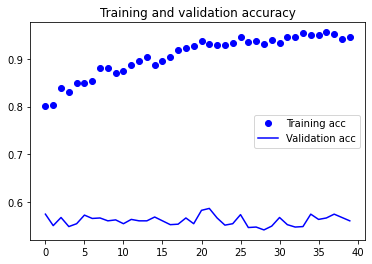

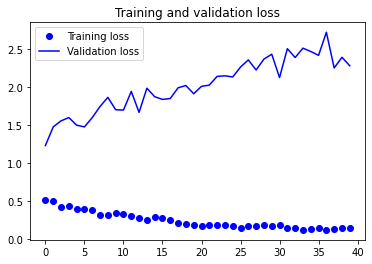

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
pred_classes = model.predict_classes(validation_features, verbose=0)

from numpy import argmax
from keras.utils.np_utils import to_categorical

pred = argmax(to_categorical(pred_classes, 5 ), axis=1)
labels = argmax(validation_labels,axis=1)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.54      0.47      0.50       200
           1       0.61      0.65      0.63       200
           2       0.63      0.67      0.65       200
           3       0.47      0.44      0.45       200
           4       0.54      0.58      0.56       200

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



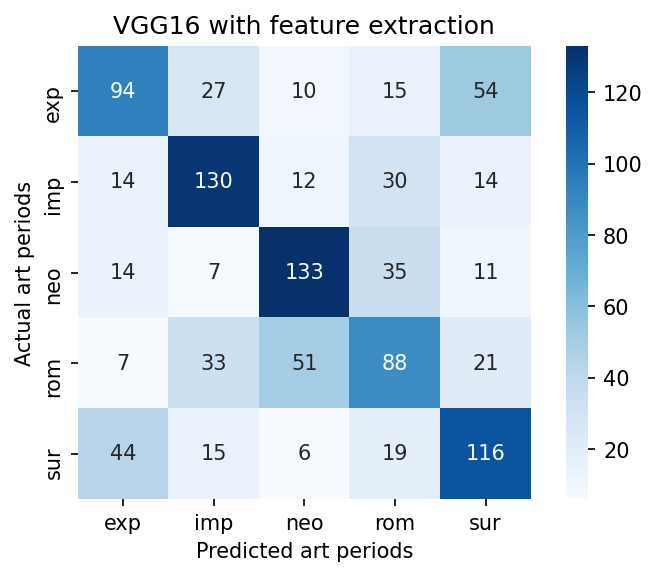

In [50]:
vgg_confusion = confusion_matrix(labels, pred)
plt.figure(dpi=150)
sns.heatmap(vgg_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['exp', 'imp', 'neo', 'rom', 'sur'],
           yticklabels=['exp', 'imp', 'neo', 'rom', 'sur']);

plt.xlabel('Predicted art periods')
plt.ylabel('Actual art periods')
plt.title('VGG16 with feature extraction');

In [31]:
validation_generator.class_indices

{'expressionism': 0,
 'impressionism': 1,
 'neoclassicism': 2,
 'romanticism': 3,
 'surrealism': 4}

In [32]:
validation_generator.filenames

['expressionism/40222.jpg',
 'expressionism/40380.jpg',
 'expressionism/4132.jpg',
 'expressionism/41403.jpg',
 'expressionism/41511.jpg',
 'expressionism/41699.jpg',
 'expressionism/41826.jpg',
 'expressionism/42095.jpg',
 'expressionism/4236.jpg',
 'expressionism/42409.jpg',
 'expressionism/42421.jpg',
 'expressionism/42583.jpg',
 'expressionism/42756.jpg',
 'expressionism/43188.jpg',
 'expressionism/4325.jpg',
 'expressionism/43313.jpg',
 'expressionism/43474.jpg',
 'expressionism/43688.jpg',
 'expressionism/43758.jpg',
 'expressionism/44235.jpg',
 'expressionism/44482.jpg',
 'expressionism/45103.jpg',
 'expressionism/45212.jpg',
 'expressionism/45473.jpg',
 'expressionism/45763.jpg',
 'expressionism/45950.jpg',
 'expressionism/46243.jpg',
 'expressionism/46486.jpg',
 'expressionism/46595.jpg',
 'expressionism/4668.jpg',
 'expressionism/46768.jpg',
 'expressionism/4682.jpg',
 'expressionism/47072.jpg',
 'expressionism/47304.jpg',
 'expressionism/47363.jpg',
 'expressionism/4746.jpg'

In [33]:
pred

array([0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 4, 0, 0, 3, 0, 4, 0, 0, 1, 0, 0,
       3, 2, 0, 4, 2, 4, 0, 0, 4, 1, 4, 3, 0, 1, 4, 4, 0, 0, 3, 0, 0, 1,
       4, 4, 0, 0, 1, 0, 0, 0, 1, 4, 0, 4, 2, 1, 0, 4, 0, 4, 0, 0, 0, 3,
       0, 0, 0, 1, 0, 0, 0, 4, 4, 1, 2, 4, 4, 0, 4, 3, 0, 4, 4, 0, 4, 0,
       4, 0, 0, 0, 1, 0, 4, 4, 2, 4, 0, 0, 0, 4, 4, 0, 1, 0, 0, 3, 1, 0,
       4, 4, 0, 0, 3, 4, 1, 4, 0, 0, 0, 1, 2, 0, 0, 0, 3, 1, 0, 4, 4, 4,
       1, 3, 0, 0, 0, 0, 1, 2, 0, 0, 4, 4, 3, 0, 3, 0, 4, 4, 0, 4, 0, 1,
       0, 0, 4, 4, 2, 3, 0, 0, 4, 0, 4, 0, 2, 4, 4, 0, 0, 4, 0, 0, 4, 3,
       0, 0, 4, 0, 4, 0, 1, 4, 0, 0, 0, 0, 1, 1, 1, 4, 4, 0, 0, 1, 0, 4,
       0, 3, 4, 1, 1, 0, 1, 1, 1, 4, 4, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 3, 1, 2, 1, 3, 3, 1, 3, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 4, 3, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 2, 1, 3, 0, 1, 3, 4, 1, 2, 3, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 0, 3, 1, 4, 0, 1, 1, 1, 1, 1, 1, 3,

In [34]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [37]:
filenames = [x for x in validation_generator.filenames]
label = [x for x in labels]
prediction = [x for x in pred]

In [43]:
pred_df = pd.DataFrame(list(zip(filenames, label, prediction)), columns = ['filenames', 'labels', 'predicted'])

In [46]:
romanticism_df = pred_df[pred_df.labels == 3]

In [54]:
romanticism_df.head(40)

,filenames,labels,predicted
600,romanticism/40196.jpg,3,3
601,romanticism/40292.jpg,3,3
602,romanticism/40357.jpg,3,2
603,romanticism/40443.jpg,3,3
604,romanticism/4091.jpg,3,3
605,romanticism/40960.jpg,3,3
606,romanticism/41049.jpg,3,3
607,romanticism/41167.jpg,3,3
608,romanticism/4154.jpg,3,2
609,romanticism/41868.jpg,3,4


In [51]:
expressionism_df = pred_df[pred_df.labels == 0]

In [56]:
expressionism_df.tail(50)

,filenames,labels,predicted
150,expressionism/68814.jpg,0,0
151,expressionism/69129.jpg,0,4
152,expressionism/69166.jpg,0,0
153,expressionism/69199.jpg,0,1
154,expressionism/69289.jpg,0,0
155,expressionism/69909.jpg,0,0
156,expressionism/69921.jpg,0,4
157,expressionism/69953.jpg,0,4
158,expressionism/7016.jpg,0,2
159,expressionism/70225.jpg,0,3
